## Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import time
from IPython import display

In [2]:
import sys
sys.path.append('../')
from src.models.convolutional_variational_autoencoder import IWAE, IWAE_MLMC

## Load the MNIST dataset
Each MNIST image is originally a vector of 784 integers, each of which is between 0-255 and represents the intensity of a pixel. We model each pixel with a Bernoulli distribution in our model, and we statically binarize the dataset.

In [3]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

In [4]:
def preprocess_images(images):
    images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
    return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

In [5]:
train_size = 60000
batch_size = 32
test_size = 10000

## Use *tf.data* to batch and shuffle the data

In [6]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

## Training and visualization

In [58]:
float_type = np.float32


In [7]:
objectives = [
    'iwelbo',
    'pearson_ubo',
    'hellinger_lbo',
    'neyman_lbo',
    'pearson_lbo',
    'hellinger_ubo',
    'neyman_ubo'
]

In [8]:
def train_epoch(model, train_dataset, obj):
    for train_x in train_dataset:
        model.train_step(train_x, obj=obj)

def generate_images(model, epoch, test_sample):
    mean, logvar = model._encode(test_sample)
    z = model._reparameterize(mean, logvar)
    predictions = model._sample(z)
    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

        
def train_and_plot(model, train_dataset, test_dataset, epochs = 10, obj='elbo'):
    num_examples_to_generate = 16

    # keeping the random vector constant for generation (prediction) so
    # it will be easier to see the improvement.
    random_vector_for_generation = tf.random.normal(
        shape=[num_examples_to_generate, latent_dim])

    # Pick a sample of the test set for generating output images
    assert batch_size >= num_examples_to_generate
    for test_batch in test_dataset.take(1):
        test_sample = test_batch[0:num_examples_to_generate, :, :, :]

    generate_images(model, 0, test_sample)
    plt.show()

    for epoch in range(1, epochs + 1):
        start_time = time.time()
        train_epoch(model, train_dataset, obj)
        end_time = time.time()

        elbo = np.mean([model.compute_elbo(test_x) for test_x in test_dataset])
        display.clear_output(wait=False)
        print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
                .format(epoch, elbo, end_time - start_time))
        generate_images(model, epoch, test_sample)
        # tight_layout minimizes the overlap between 2 sub-plots
        #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
        plt.show()

In [9]:
def _plot_convergence(model, test_dataset, obj, grad=False):
    
    tmp_dataset = (tf.data.Dataset.from_tensor_slices(test_images[:100])
                    .shuffle(100).batch(1))
    
    def get_grad(x, K):
        with tf.GradientTape() as tape:
            _obj =  model._compute_dobjective(x, K, obj)
            gradients = tape.gradient(_obj, model._decoder.trainable_variables)
        gradients = tf.concat([tf.reshape(g,[-1]) for g in gradients], axis=0)
        return gradients
    
    def get_L2_norm(L):
        L2 = 0
        for x in tmp_dataset:
            if grad==False:  L2 += model._compute_dobjective(x, 2**L, obj)**2
            elif grad==True: L2 += get_grad(x, 2**L)**2
        return np.sum(L2/100)
    
    # evaluation of L2 norms
    levels = np.arange(10)
    res = [get_L2_norm(l) for l in levels]
    
    # plot
    plt.plot([2**l for l in levels], res)
    plt.plot([2**l for l in levels], [res[1]*2.**(1.5-l) for l in levels], c='gray')
    plt.plot([2**l for l in levels], [res[1]*2.**(1.5-2*l) for l in levels], c='gray')
    plt.yscale('log')
    plt.xscale('log')
    if grad==False: plt.legend([r'$\sqrt{E[||\Delta f||_2^2]}$', r'$O(2^{-\ell})$', r'$O(2^{-2\ell})$'])
    elif grad==True: plt.legend([r'$\sqrt{E[||\Delta \nabla f||_2^2]}$', r'$O(2^{-\ell})$', r'$O(2^{-2\ell})$'])
    
    return res
        
def plot_convergence(model, test_dataset, obj):
    res = {}
    plt.subplot(1,2,1)
    res['obj'] = _plot_convergence(model, test_dataset, obj, grad=False)
    plt.subplot(1,2,2)
    res['grad'] = _plot_convergence(model, test_dataset, obj, grad=True)
    return res

In [38]:
def _plot_convergence_sumo(model, test_dataset, obj, grad=False, cross=False):
    
    def compute_dobjective_sumo(model, x, K):
        prob_ratios = model._compute_prob_ratios(x, K)
        _obj = tf.reduce_sum(model._compute_objectives(prob_ratios, obj))
        _obj -= tf.reduce_sum(model._compute_objectives(prob_ratios[:,:K-1], obj))
        return _obj
    

    def compute_cross_dobjective_sumo(model, x, K):
        '''
        Ad-hock implementaion for the evaluation of cross term. You can use this function by:

        latent_dim = 3
        model = IWAE_MLMC(latent_dim)
        _ = _plot_convergence_sumo(model, test_dataset, obj, grad=False, cross=True)
        '''
        prob_ratios = model._compute_prob_ratios(x, K+5)
        _obj1 = tf.reduce_sum(model._compute_objectives(prob_ratios, obj))
        _obj1 -= tf.reduce_sum(model._compute_objectives(prob_ratios[:,:K+4], obj))
        _obj2 = tf.reduce_sum(model._compute_objectives(prob_ratios[:,:K+1], obj))
        _obj2 -= tf.reduce_sum(model._compute_objectives(prob_ratios[:,:K], obj))
        return _obj1 * _obj2
    
    def get_grad(x, K):
        with tf.GradientTape() as tape:
            _obj = compute_dobjective_sumo(model, x, K)
            gradients = tape.gradient(_obj, model._decoder.trainable_variables)
        gradients = tf.concat([tf.reshape(g,[-1]) for g in gradients], axis=0)
        return gradients
    
    def get_L2_norm(L):
        L2 = 0
        for x in tmp_dataset:
            if cross==True:  L2 += np.abs(compute_cross_dobjective_sumo(model, x, 2**L))
            if grad==False:  L2 += compute_dobjective_sumo(model, x, 2**L)**2
            elif grad==True: L2 += get_grad(x, 2**L)**2
        return np.sum(L2/100)
    
    tmp_dataset = (tf.data.Dataset.from_tensor_slices(test_images[:100])
                    .shuffle(100).batch(1))
    
    # evaluation of L2 norms
    levels = np.arange(10)
    res = [get_L2_norm(l) for l in levels]
    
    # plot
    plt.plot([2**l for l in levels], res)
    plt.plot([2**l for l in levels], [res[1]*2.**(1.5-l) for l in levels], c='gray')
    plt.plot([2**l for l in levels], [res[1]*2.**(1.5-2*l) for l in levels], c='gray')
    plt.yscale('log')
    plt.xscale('log')
    if grad==False: plt.legend([r'$E[||\Delta f||_2^2]$', r'$O(2^{-\ell})$', r'$O(2^{-2\ell})$'])
    elif grad==True: plt.legend([r'$E[||\Delta \nabla f||_2^2]$', r'$O(2^{-\ell})$', r'$O(2^{-2\ell})$'])
    
    return res
        
def plot_convergence_sumo(model, test_dataset, obj):
    res = {}
    plt.subplot(1,2,1)
    res['obj'] = _plot_convergence_sumo(model, test_dataset, obj, grad=False)
    plt.subplot(1,2,2)
    res['grad'] = _plot_convergence_sumo(model, test_dataset, obj, grad=True)
    return res

In [104]:
class IWELBO_SUMO(IWAE_MLMC):
    
    def compute_IWELBO_sumo(self, x, K_max=8):
        N = x.shape[0]

        Us = tf.random.uniform(shape=[N], dtype=tf.float64)
        Ks = tf.minimum(1/Us, tf.cast(K_max, tf.float64))
        Ks = tf.cast(tf.math.floor(Ks), tf.int64)
        unique, _, counts =  tf.unique_with_counts(tf.sort(Ks))

        offset = 0
        iwelbo = 0
        for K, cnt in zip(unique, counts):
            x_tmp = x[offset:offset+cnt]
            iwelbo += (1/N) * tf.reduce_sum( self.conditional_IWELBO_SUMO(x_tmp, K) ) 
            offset += cnt

        return iwelbo

    
    def conditional_IWELBO_SUMO(self, x, K):
        # compute SUMO est.
        prob_ratios = self._compute_prob_ratios(x,K)
        ks = tf.reshape( tf.cast( tf.range(0,K) + 1, float_type), [1,K])
        cum_iwelbo = tf.math.cumulative_logsumexp(prob_ratios, axis=1) - tf.math.log(ks)
        inv_weights = ks
        iwelbo = cum_iwelbo[:,0] + tf.reduce_sum(inv_weights[:,1:] * (cum_iwelbo[:,1:] - cum_iwelbo[:,:K-1]), axis=1)
        return iwelbo
    

In [105]:
model = IWELBO_SUMO(3)

In [112]:
for i in range(7):
    train_epoch(model, train_dataset, 'elbo')

In [135]:
res = {'sumo':[],'mlmc':[],'nmc':[]}
levels = [i for i in range(10)]
for l in levels:
    for train_x in train_dataset:
        a = [model.compute_IWELBO_sumo(train_x, 2**l) for i in range(1000)]
        b = [model.compute_objective_mlmc(train_x, max_level=l, obj='iwelbo', b=0.45, randomize=True) for i in range(1000)]
        c = [model.compute_objective(train_x[:8], K=2**l, obj='iwelbo') for i in range(1000)]
        res['sumo'].append(np.var(a))
        res['mlmc'].append(np.var(b))
        res['nmc'].append(np.var(c)/4)
        break

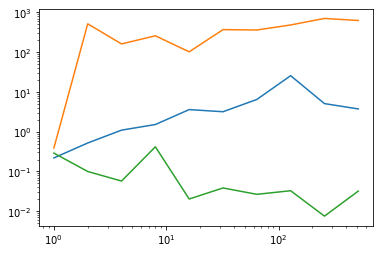

In [136]:
# plot
plt.plot(ks, res['sumo'])# V_sumo=O(log K) or O(K), C_sumo=O(log K)
plt.plot(ks, res['mlmc'])# V_mlmc=O(K^0.475), C_mlmc=O(K^0.475), 
plt.plot(ks, res['nmc'])#  V_nmc =O(1), C_nmc=O(K)
plt.yscale('log')
plt.xscale('log')

In [293]:
res = {'sumo':[],'mlmc':[]}
levels = [i for i in range(13)]
for l in levels:
    for train_x in train_dataset:
        a = [model.compute_IWELBO_sumo(train_x, 2**l) for i in range(1000)]
        b = [model.compute_objective_mlmc(train_x, max_level=l, obj='iwelbo', b=0.45, w0=10/(10+l), randomize=True) for i in range(1000)]
        res['sumo'].append(np.var(a))
        res['mlmc'].append(np.var(b))
        break

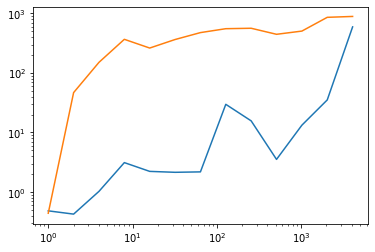

In [294]:
# plot
ks = [2**l for l in range(13)]
plt.plot(ks, res['sumo'])
plt.plot(ks, res['mlmc'])
plt.yscale('log')
plt.xscale('log')

# The tragedic failure of MLMC coupling

The LHS is 2nd moment of the difference of iwelbo and the RHS is that of its gradients (measured by L2 norm).

In [24]:
latent_dim = 3
model = IWAE_MLMC(latent_dim)

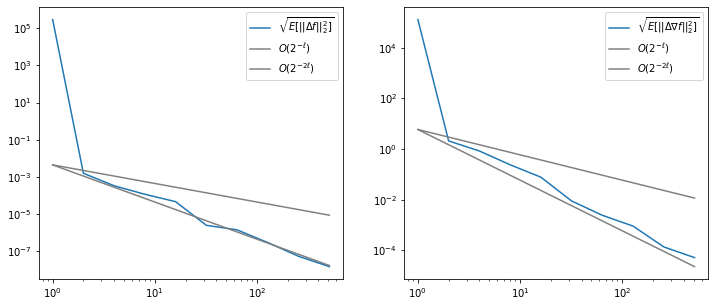

In [25]:
# before training
plt.figure(figsize=[12,5])
_ = plot_convergence(model, test_dataset, 'iwelbo')

In [26]:
for i in range(7):
    train_epoch(model, train_dataset, 'elbo')

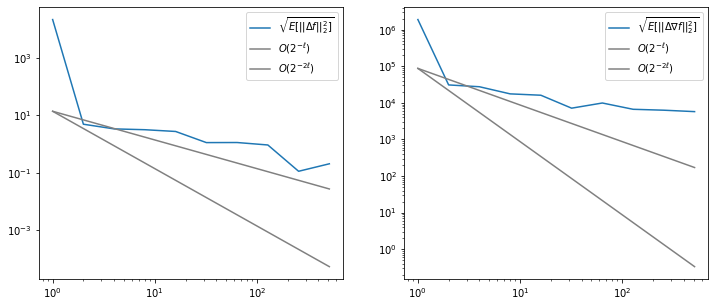

In [27]:
# after training
plt.figure(figsize=[12,5])
_ = plot_convergence(model, test_dataset, 'iwelbo')

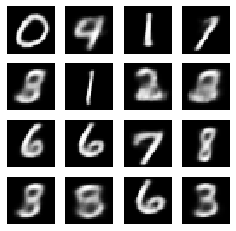

In [28]:
# visualize the learned model
for test_batch in test_dataset.take(1):
    test_sample = test_batch[0:16, :, :, :]

generate_images(model, 0, test_sample)
plt.show()

# Experimenting coupling of various objectives
Plots are output in the `../out/convolutional_variational_autoencoder/` as PNG files.

In [21]:
latent_dim = 3
model = IWAE_MLMC(latent_dim)

In [22]:
# set the dimensionality of the latent space to a plane for visualization later
res = {}
res_sumo = {}
n_epochs = 3
for epoch in range(n_epochs+1):
    for obj in objectives:
        print('#epoch: {}, plotting convergence of {}'.format(epoch, obj))
        # mlmc
        plt.figure(figsize=[15,10])
        res_tmp = plot_convergence(model, test_dataset, obj)
        res['{}_{}'.format(obj, epoch)] = res_tmp['obj']
        res['{}_grad_{}'.format(obj, epoch)] = res_tmp['grad']
        plt.savefig('../out/convolutional_variational_autoencoder/convergence_mlmc_{}_{}_epoch(s).png'.format(obj, epoch))
        plt.close('all')
        #sumo
        plt.figure(figsize=[15,10])
        res_tmp = plot_convergence_sumo(model, test_dataset, obj)
        res_sumo['{}_{}'.format(obj, epoch)] = res_tmp['obj']
        res_sumo['{}_grad_{}'.format(obj, epoch)] = res_tmp['grad']
        plt.savefig('../out/convolutional_variational_autoencoder/convergence_sumo_{}_{}_epoch(s).png'.format(obj, epoch))
        plt.close('all')
    if epoch==n_epochs: break
    print('now training ... \r'.format(epoch, obj))
    train_epoch(model, train_dataset, 'elbo')
# save results to the csv
_hash = int(time.time())%10000000
pd.DataFrame(res).to_csv('../out/convolutional_variational_autoencoder/mlmc_{}.csv'.format(_hash))
pd.DataFrame(res_sumo).to_csv('../out/convolutional_variational_autoencoder/sumo_{}.csv'.format(_hash))

#epoch: 0, plotting convergence of iwelbo
#epoch: 0, plotting convergence of pearson_ubo
#epoch: 0, plotting convergence of hellinger_lbo
#epoch: 0, plotting convergence of neyman_lbo
#epoch: 0, plotting convergence of pearson_lbo
#epoch: 0, plotting convergence of hellinger_ubo
#epoch: 0, plotting convergence of neyman_ubo
now training ... 
#epoch: 1, plotting convergence of iwelbo
#epoch: 1, plotting convergence of pearson_ubo
#epoch: 1, plotting convergence of hellinger_lbo
#epoch: 1, plotting convergence of neyman_lbo
#epoch: 1, plotting convergence of pearson_lbo
#epoch: 1, plotting convergence of hellinger_ubo
#epoch: 1, plotting convergence of neyman_ubo
now training ... 
#epoch: 2, plotting convergence of iwelbo
#epoch: 2, plotting convergence of pearson_ubo
#epoch: 2, plotting convergence of hellinger_lbo
#epoch: 2, plotting convergence of neyman_lbo
#epoch: 2, plotting convergence of pearson_lbo
#epoch: 2, plotting convergence of hellinger_ubo
#epoch: 2, plotting convergence 